In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import torch
import utils
from torch.utils.data import DataLoader
import train_vip
import matplotlib.pyplot as plt
from archs.vip_network import Network
import tqdm
import copy
import matplotlib
import pandas as pd
import torchvision

import clip 
import train_concept_qa
model_clip, preprocess = clip.load("ViT-B/16", device=torch.device("cuda"))

In [67]:
dataset_name = "cifar10"


MAX_QUERIES = train_vip.get_max_queries(dataset_name)
UNCERTAINTY = False

max_queries = MAX_QUERIES
concept_net = train_vip.get_answering_model(dataset_name = dataset_name, MAX_QUERIES=MAX_QUERIES).cuda()

actor, classifier = train_vip.get_vip_networks(dataset_name, mode="random", MAX_QUERIES=MAX_QUERIES)


actor_filename, classifier_filename = utils.get_pretrained_actor_classifier_filenames(dataset_name)


actor.load_state_dict(torch.load(actor_filename))
classifier.load_state_dict(torch.load(classifier_filename))


actor.eval()
classifier.eval()
concept_net.eval()

ConceptNet2(
  (layer1): Linear(in_features=1024, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=64, bias=True)
  (norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (head): Linear(in_features=64, out_features=1, bias=True)
)

In [68]:
#for Imagenet and Places365 datasets, replace the filepaths below with the filepath where your places365 and imagene datasets are located.

if dataset_name == "imagenet":
    train_ds = torchvision.datasets.ImageFolder(f'/cis/project/vision_sequences/ImageNet-ImageFolderFormat/train/', transform=preprocess)
    test_ds = torchvision.datasets.ImageFolder(f'/cis/project/vision_sequences/ImageNet-ImageFolderFormat/val/', transform=preprocess)

elif dataset_name == "places365":
    train_ds = torchvision.datasets.Places365(root='/cis/project/vision_sequences/Places365', split="train-standard", small=True,download=False, transform=preprocess)
    test_ds = torchvision.datasets.Places365(root='/cis/project/vision_sequences/Places365', split="val", small=True,download=False, transform=preprocess)
    
else:
    train_ds, test_ds = utils.get_data(dataset_name, preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [69]:
with torch.no_grad():
    concepts = utils.get_concepts("./concept_sets/" + dataset_name + ".txt")
    text = clip.tokenize(concepts).to(torch.device("cuda"))
    text_features = model_clip.encode_text(text)
    dictionary = text_features.T

    dictionary = dictionary / torch.linalg.norm(dictionary, axis=0)

In [70]:
class_labels = np.array([name.strip().split(",")[0] for name in open(f"label_sets/{dataset_name}.txt","r").readlines()])

def Answer(value):
        if value == 1:
            return "Yes"
        elif value == -1:
            return "No"
        
        
def plot_trajectory(index, stopping_confidence):
    
    with torch.no_grad():
        x, y = test_ds[index]
        
        image_features = model_clip.encode_image(x.unsqueeze(0).cuda())
        
        image_features = image_features / torch.linalg.norm(image_features, axis=1).reshape(-1, 1)
        
        image_features = image_features.repeat(dictionary.size(1), 1, 1).permute(1, 0, 2)
        dictionary_extended = dictionary.T.repeat(image_features.size(0), 1, 1)

        input_features = torch.cat((image_features, dictionary_extended), dim=2)
        input_features = torch.flatten(input_features, 0, 1)
        
        query_preds = concept_net(input_features.float()).squeeze().view((1, dictionary.size(1)))
        
            
        if UNCERTAINTY == True:
            query_preds = torch.bernoulli(torch.nn.Sigmoid()(query_preds))
               
        x = torch.where((query_preds > -0.4), torch.ones(query_preds.size()).cuda(), -torch.ones(query_preds.size()).cuda())
        y = torch.tensor(y).cuda()

        predicted_label = classifier(x).argmax(dim=1)


        acc, logits, queries, mask = utils.verbose_sequential(x, y, max_queries, actor, classifier)
    
    print ("Label:", class_labels[y.item()])

    queries_needed = min(utils.compute_queries_needed(logits, threshold=stopping_confidence)[0].item(), 20)

    
    ylabels = [f'0. ' + "Init"]
    labelcolors = [2]
    for ind, query in enumerate(queries):
        if queries_needed == ind:
            break
#         print (f"{ind}.", list_of_concepts[query.argmax().item()] + "?", Answer(x[0, query.argmax().item()]))
        
        if concepts[query.argmax().item()] == "on an animal":
            ylabels.append(f'{ind+1}. an animal')
        else:
            ylabels.append(f'{ind+1}. {concepts[query.argmax().item()]}')
        
        labelcolors.append(int(x[0, query.argmax().item()]))
        
    labelcolors = np.array(labelcolors)
#     plt.close()

    indices = logits[0, ind].argsort(descending=True)[:10].numpy()
    
        
    np.random.shuffle(indices)
    
    fig, ax = plt.subplots(figsize=(15,10), dpi=150)
    im = ax.imshow(torch.nn.Softmax()(logits[0]).cpu().numpy()[:queries_needed + 1][:,indices], cmap="coolwarm", vmin=0.0, vmax=1.0)
    ax.set_yticks(np.arange(queries_needed + 1))
    ax.set_yticklabels(ylabels)
    ax.yaxis.set_ticks_position("right")
    ax.set_xticks(np.arange(len(indices)))

    
    ax.set_xticklabels(class_labels[indices], rotation=-45, ha="left")
    fig.colorbar(im, ax=ax, pad=0.02, location="left")
    [t.set_color(np.array(['red', 'green', 'gray', 'red'])[i]) for (i, t) in zip(labelcolors, ax.yaxis.get_ticklabels())]

#     fig.tight_layout()
    
    return indices, predicted_label.item()

Label: horse
horse


<ipython-input-70-c487b8b1dfa8>:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  im = ax.imshow(torch.nn.Softmax()(logits[0]).cpu().numpy()[:queries_needed + 1][:,indices], cmap="coolwarm", vmin=0.0, vmax=1.0)


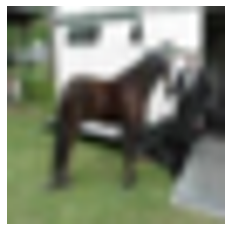

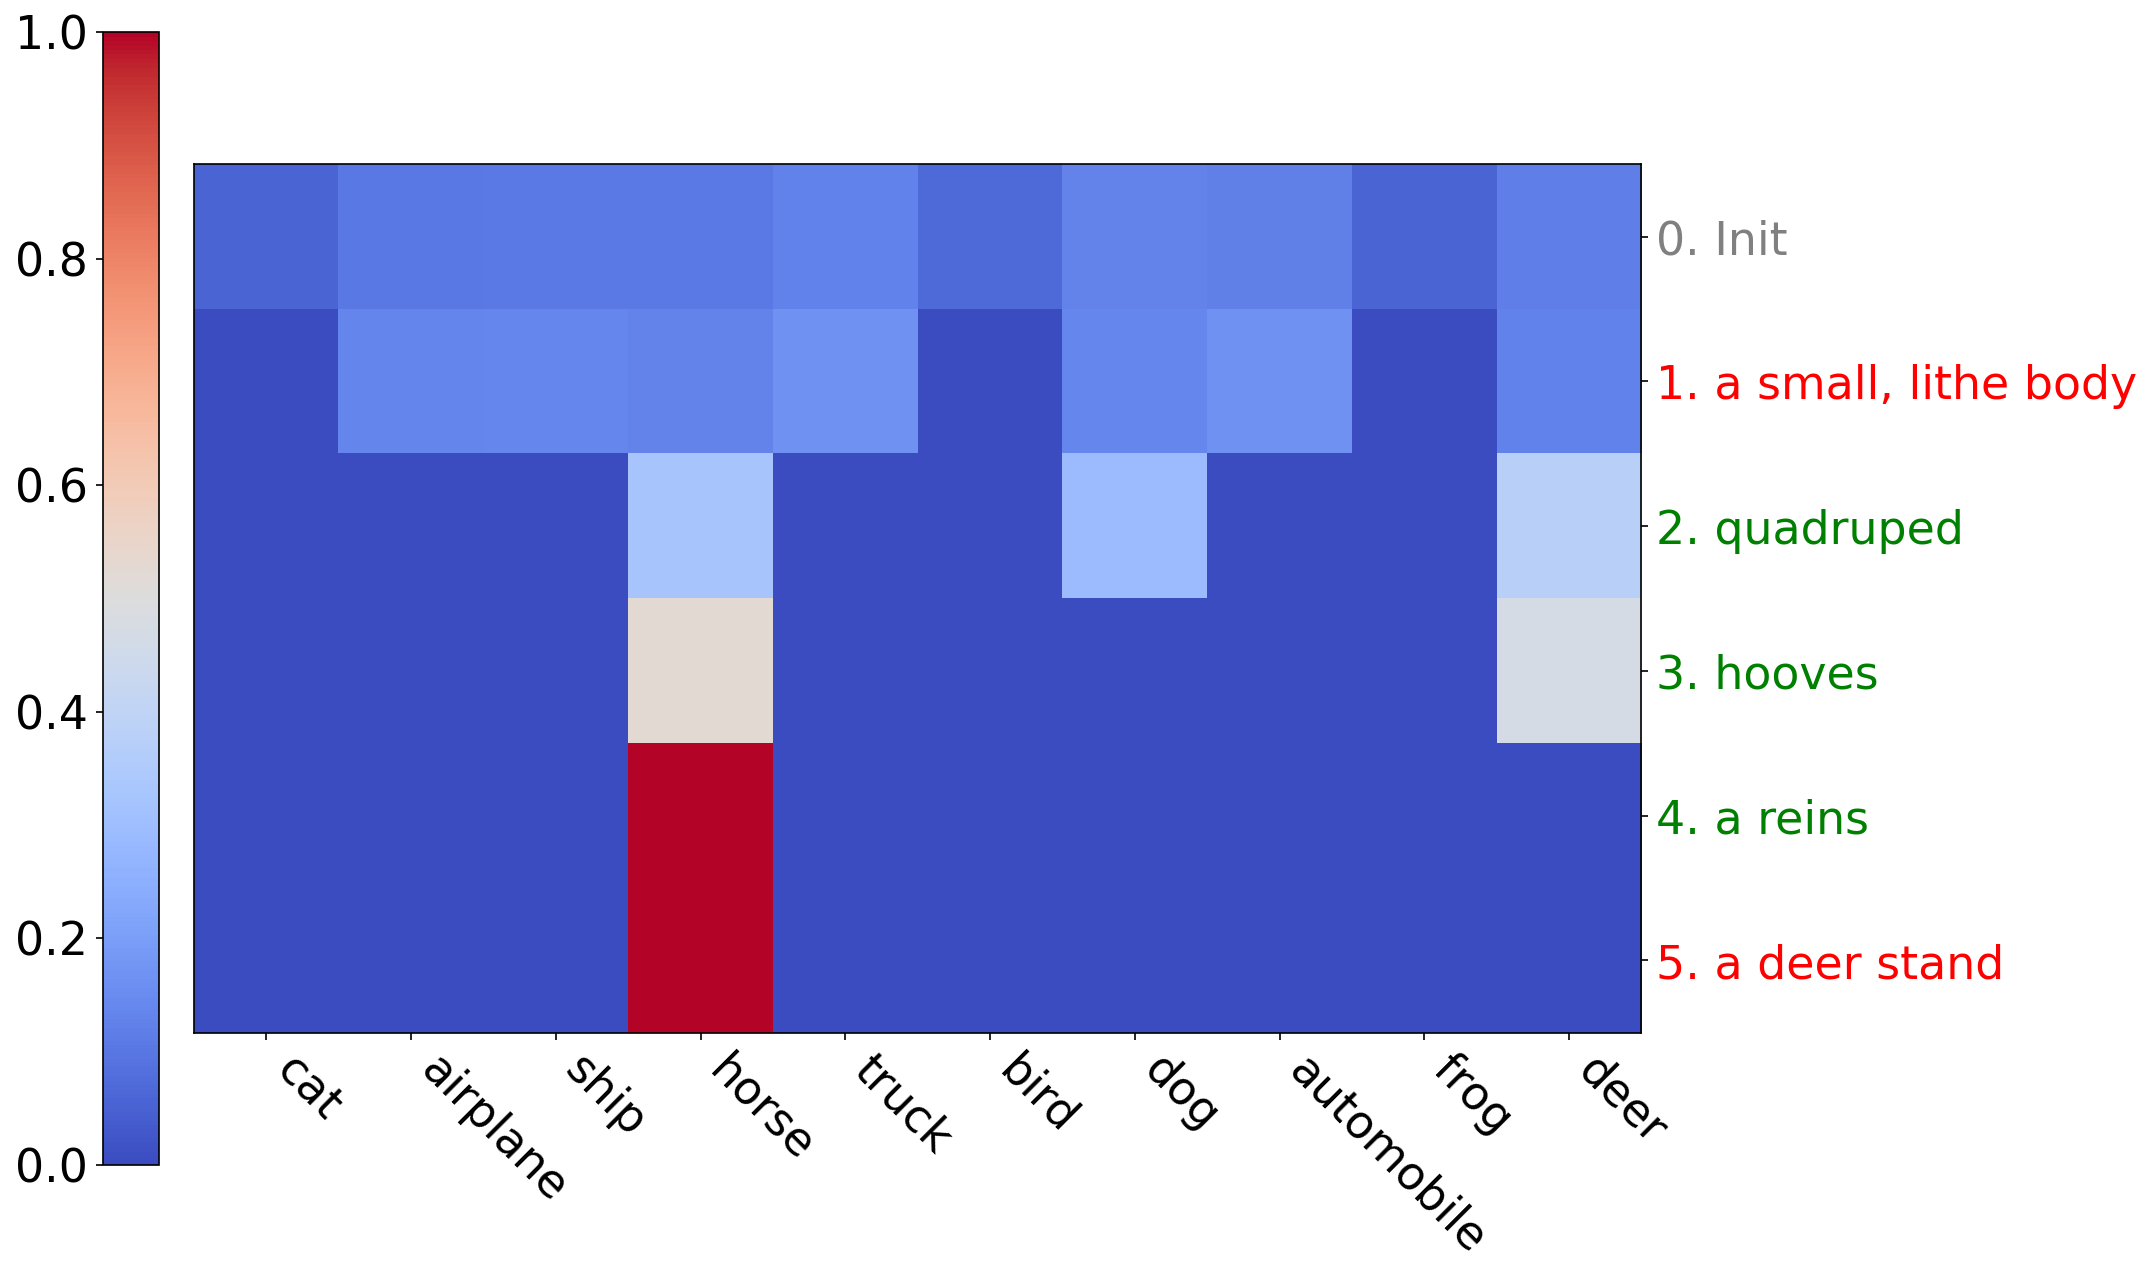

In [71]:
mean = np.array([0.48145466, 0.4578275, 0.40821073]).reshape((1,1,3))

std = np.array([0.26862954, 0.26130258, 0.27577711]).reshape((1,1,3))

stopping_confidence = 0.8 

index = 20 #347*50 + 1
start_index = 0
img, label = test_ds[index + start_index]


plt.figure()
plt.rcParams.update({'font.size': 22})
plt.imshow(img.permute(1, 2, 0).numpy()*std + mean)
plt.axis("off")

indices, predicted_label = plot_trajectory(index + start_index, stopping_confidence)

print (class_labels[predicted_label])